函式庫導入完成。

字體已設定為 'Microsoft JhengHei' (微軟正黑體)，適用於 Windows。
成功使用 'utf-8-sig' 編碼讀取檔案: 2023資料剖析後內容1~8月芝山到天母0609整理二版.csv

原始資料共有 5016 筆。

--- 步驟 2：開始進行資料清理 ---

發現 1 筆 'Time2' 欄位格式錯誤的資料。

移除格式錯誤的資料後，剩餘 5015 筆。
再移除 5 筆騎乘時間極端的資料。
資料清理完成，最終有效資料共 5010 筆。

--- 步驟 3：開始進行探索性資料分析 (EDA) ---

【核心統計數據】
平均數: 871.38 秒 (約 14 分 31 秒)
中位數: 802.00 秒 (約 13 分 22 秒)
眾數:   663.00 秒 (約 11 分 3 秒)

正在繪製盒鬚圖...


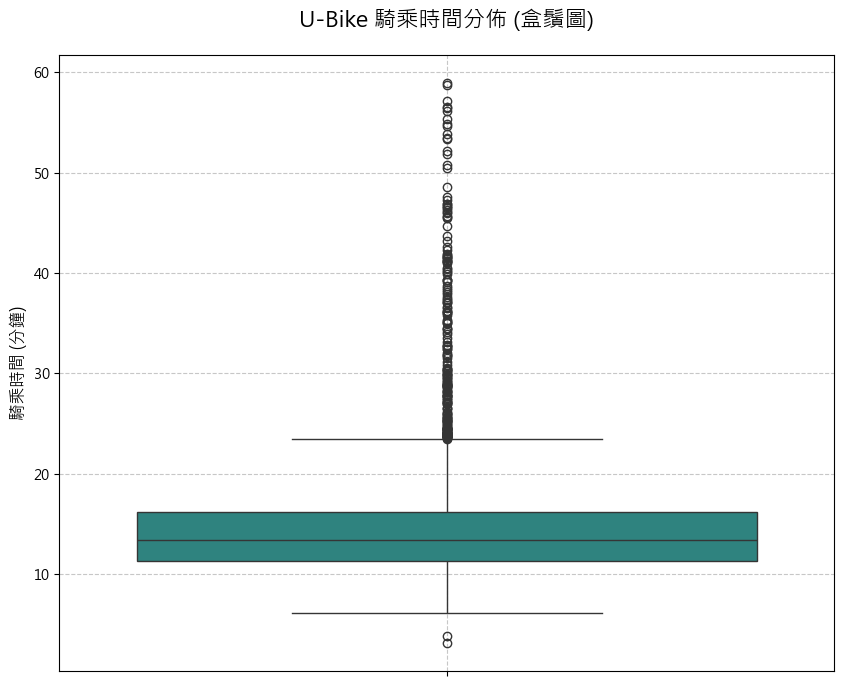

正在繪製常態分配圖...


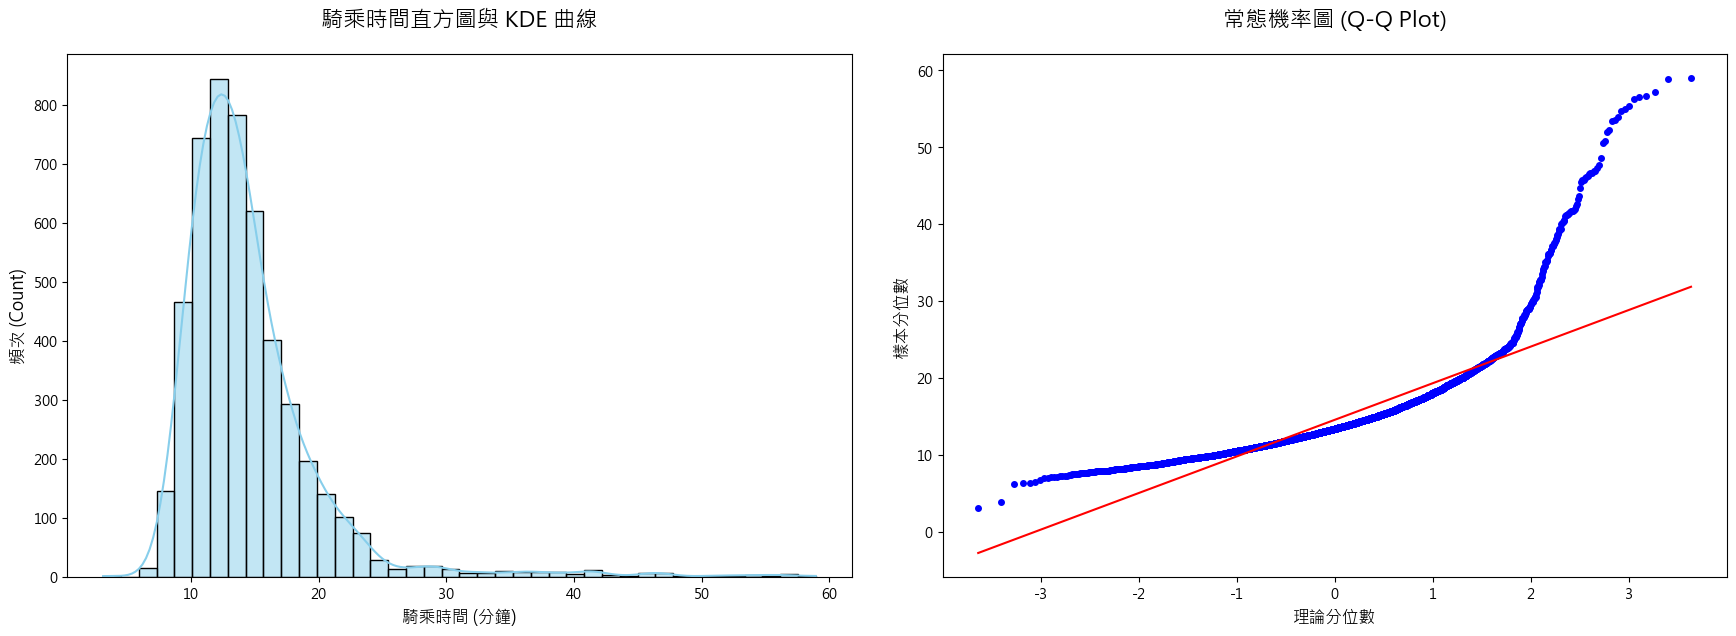


--- 步驟 4：開始進行特徵工程 ---
特徵工程完成。
最終用於建模的欄位： ['Unnamed7', 'TotalSeconds', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsRushHour', 'StartExit_Exit_1', 'StartExit_Exit_2']

--- 步驟 5：開始訓練 LightGBM 模型 ---
訓練集大小: 4008 筆, 測試集大小: 1002 筆。
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 4008, number of used features: 7
[LightGBM] [Info] Start training from score 872.293663
模型訓練完成！

--- 步驟 6：模型評估與結果分析 ---

平均絕對誤差 (MAE): 213.58 秒 (約 3 分 33 秒)
決定係數 (R-squared, R²): -0.03

正在繪製「預測值 vs. 實際值」圖...


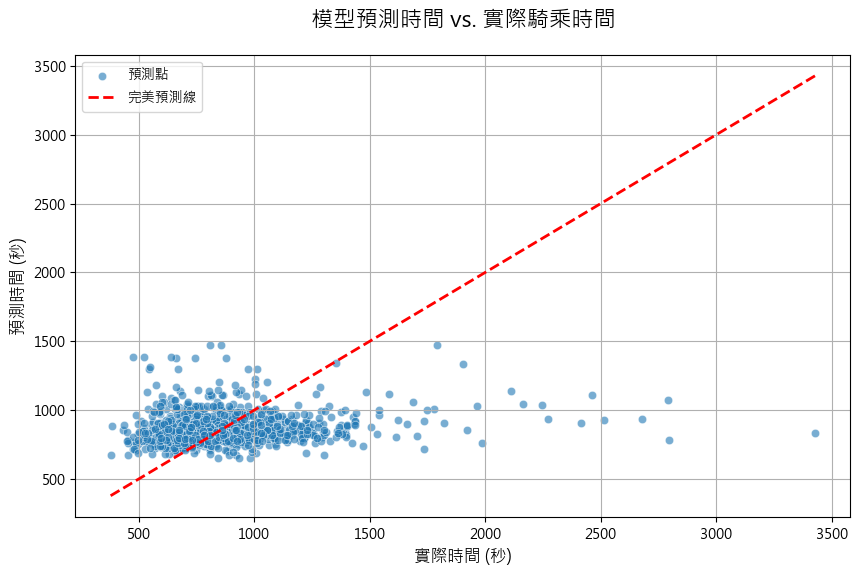


正在繪製特徵重要性圖...


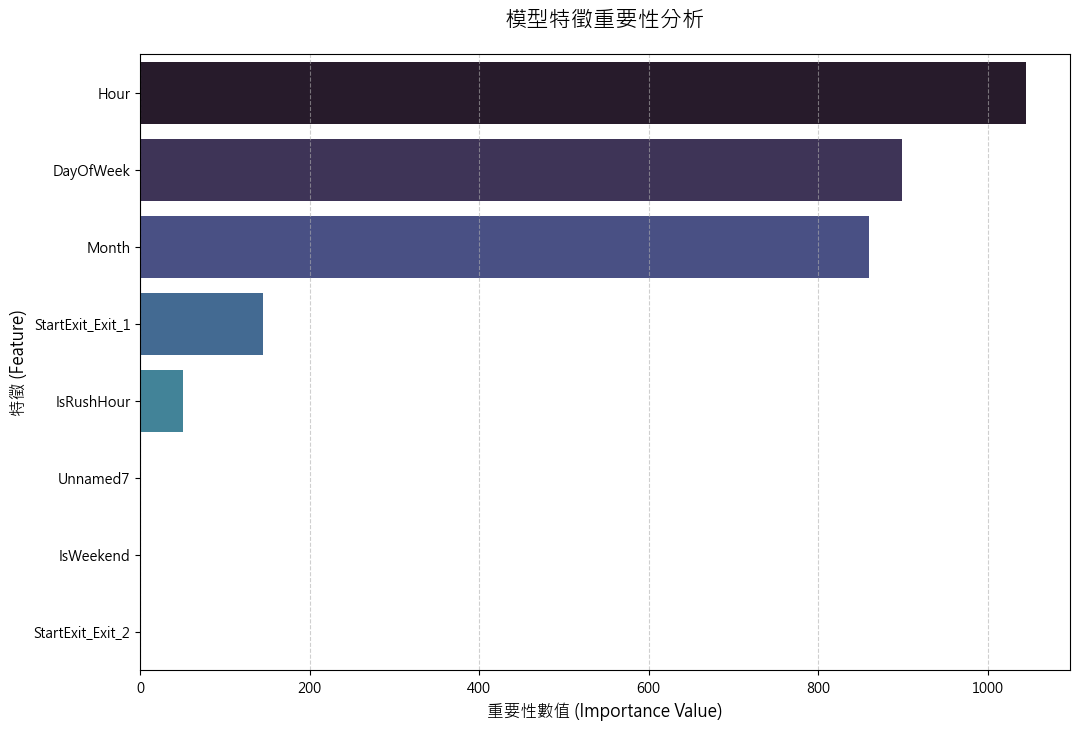


--- 專案執行完畢 ---


In [2]:
# =============================================================================
# 專案：U-Bike 騎乘時間預測模型 (最終版)
# 描述：本腳本涵蓋從資料清理、探索性分析、特徵工程到模型訓練與評估的完整流程。
# 模型：LightGBM Regressor
# 修正：
#   1. 針對 Windows 11 的 'Microsoft JhengHei' 字體設定，解決中文亂碼。
#   2. 採用穩健的時間格式轉換，解決 pandas 誤讀 MM:SS 為 HH:MM 的問題。
#   3. 清理欄位名稱中的特殊字元，解決 LightGBM 不支援的問題。
#   4. 加入眾數計算。
# =============================================================================

# 步驟 0：導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import warnings
import re # 導入正規表示式函式庫

warnings.filterwarnings('ignore', category=FutureWarning)
print("函式庫導入完成。\n")

# =============================================================================
# 步驟 1：資料載入與視覺化設定
# =============================================================================
try:
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False 
    print("字體已設定為 'Microsoft JhengHei' (微軟正黑體)，適用於 Windows。")
except Exception as e:
    print(f"警告：設定中文字體時發生錯誤: {e}")

file_path = u'2023資料剖析後內容1~8月芝山到天母0609整理二版.csv' 
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
    print(f"成功使用 'utf-8-sig' 編碼讀取檔案: {file_path}")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='big5')
    print(f"成功使用 'big5' 編碼讀取檔案: {file_path}")
except FileNotFoundError:
    print(f"錯誤：找不到檔案 '{file_path}'。請確認檔案名稱和路徑是否正確。")
    exit()

print(f"\n原始資料共有 {len(df)} 筆。")


# =============================================================================
# 步驟 2：穩健的資料清理與預處理
# =============================================================================
print("\n--- 步驟 2：開始進行資料清理 ---")

# 移除檔案結尾可能存在的文字說明行 (判斷依據：Date 欄位為空或非數字)
df.dropna(subset=['Date'], inplace=True, how='all')
df = df[pd.to_numeric(df['Date'], errors='coerce').notna()].copy()

# 核心修正：將 'Time2' 欄位強制轉為字串，並在前面加上 '0:'
df['Time2_formatted'] = '0:' + df['Time2'].astype(str).str.strip()
timedeltas = pd.to_timedelta(df['Time2_formatted'], errors='coerce')

# 診斷步驟：找出並顯示轉換失敗的資料
problematic_rows = df[timedeltas.isna()]
if not problematic_rows.empty:
    print(f"\n發現 {len(problematic_rows)} 筆 'Time2' 欄位格式錯誤的資料。")

# 清理轉換失敗的資料並建立 'TotalSeconds' 欄位
df['TotalSeconds'] = timedeltas.dt.total_seconds()
df.dropna(subset=['TotalSeconds'], inplace=True)
print(f"\n移除格式錯誤的資料後，剩餘 {len(df)} 筆。")

# 移除不合理的極端值
original_rows = len(df)
df = df[(df['TotalSeconds'] >= 180) & (df['TotalSeconds'] <= 3600)].copy()
print(f"再移除 {original_rows - len(df)} 筆騎乘時間極端的資料。")

if len(df) == 0:
    print("\n【錯誤】經過清理後，沒有剩餘的有效資料可供分析。")
    exit()
    
df['TotalSeconds'] = df['TotalSeconds'].astype(int)
df['TotalMinutes'] = df['TotalSeconds'] / 60
print(f"資料清理完成，最終有效資料共 {len(df)} 筆。")


# =============================================================================
# 步驟 3：探索性資料分析 (EDA)
# =============================================================================
print("\n--- 步驟 3：開始進行探索性資料分析 (EDA) ---")

# 3.1 計算核心統計數據
mean_seconds = df['TotalSeconds'].mean()
median_seconds = df['TotalSeconds'].median()
mode_seconds = df['TotalSeconds'].mode()[0] # mode()可能回傳多個值，取第一個

print("\n【核心統計數據】")
print(f"平均數: {mean_seconds:.2f} 秒 (約 {int(mean_seconds // 60)} 分 {int(mean_seconds % 60)} 秒)")
print(f"中位數: {median_seconds:.2f} 秒 (約 {int(median_seconds // 60)} 分 {int(median_seconds % 60)} 秒)")
print(f"眾數:   {mode_seconds:.2f} 秒 (約 {int(mode_seconds // 60)} 分 {int(mode_seconds % 60)} 秒)")

# 3.2 繪製盒鬚圖 (Box Plot)
print("\n正在繪製盒鬚圖...")
plt.figure(figsize=(10, 8))
sns.boxplot(y=df['TotalMinutes'], palette="viridis")
plt.title('U-Bike 騎乘時間分佈 (盒鬚圖)', fontsize=16, pad=20)
plt.ylabel('騎乘時間 (分鐘)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3.3 繪製常態分配圖 (Normality Plot)
print("正在繪製常態分配圖...")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.histplot(df['TotalMinutes'], kde=True, ax=axes[0], bins=40, color='skyblue')
axes[0].set_title('騎乘時間直方圖與 KDE 曲線', fontsize=16, pad=20)
axes[0].set_xlabel('騎乘時間 (分鐘)', fontsize=12)
axes[0].set_ylabel('頻次 (Count)', fontsize=12)
stats.probplot(df['TotalMinutes'], dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor('b'); axes[1].get_lines()[0].set_markeredgecolor('b')
axes[1].get_lines()[0].set_markersize(4.0); axes[1].get_lines()[1].set_color('r')
axes[1].set_title('常態機率圖 (Q-Q Plot)', fontsize=16, pad=20)
axes[1].set_xlabel('理論分位數', fontsize=12)
axes[1].set_ylabel('樣本分位數', fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


# =============================================================================
# 步驟 4：特徵工程 (Feature Engineering)
# =============================================================================
print("\n--- 步驟 4：開始進行特徵工程 ---")

df['Date'] = df['Date'].astype(int).astype(str)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time1'], format='%Y%m%d %H:%M:%S')
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['IsRushHour'] = df['Hour'].apply(lambda h: 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0)

def normalize_exit(stp_name):
    return 'Exit_1' if '1號' in str(stp_name) else 'Exit_2'
df['StartExit'] = df['Stp1'].apply(normalize_exit)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int64)
encoded_features = ohe.fit_transform(df[['StartExit']])
new_feature_names = ohe.get_feature_names_out(['StartExit'])
encoded_df = pd.DataFrame(encoded_features, columns=new_feature_names, index=df.index)
df = pd.concat([df, encoded_df], axis=1)

columns_to_drop = ['Date', 'Week', 'Time1', 'AM/PM', 'Stp1', 'Stp2', 'Time2', 
                   'TotalMinutes', 'Datetime', 'StartExit', 'Time2_formatted']
df_model = df.drop(columns=columns_to_drop, errors='ignore')

# 清理所有欄位名稱，移除 LightGBM 不支援的特殊字元
df_model.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df_model.columns]

print("特徵工程完成。")
print("最終用於建模的欄位：", df_model.columns.tolist())


# =============================================================================
# 步驟 5：模型訓練 (Model Training)
# =============================================================================
print("\n--- 步驟 5：開始訓練 LightGBM 模型 ---")

target = 'TotalSeconds'
features = [col for col in df_model.columns if col != target]
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"訓練集大小: {X_train.shape[0]} 筆, 測試集大小: {X_test.shape[0]} 筆。")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
print("模型訓練完成！")


# =============================================================================
# 步驟 6：模型評估與視覺化 (Model Evaluation & Visualization)
# =============================================================================
print("\n--- 步驟 6：模型評估與結果分析 ---")

y_pred = lgbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae_minutes = int(mae // 60)
mae_seconds = int(mae % 60)
r2 = r2_score(y_test, y_pred)

print(f"\n平均絕對誤差 (MAE): {mae:.2f} 秒 (約 {mae_minutes} 分 {mae_seconds} 秒)")
print(f"決定係數 (R-squared, R²): {r2:.2f}")

print("\n正在繪製「預測值 vs. 實際值」圖...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='預測點')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label='完美預測線')
plt.title('模型預測時間 vs. 實際騎乘時間', fontsize=16, pad=20)
plt.xlabel('實際時間 (秒)', fontsize=12)
plt.ylabel('預測時間 (秒)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

print("\n正在繪製特徵重要性圖...")
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), palette="mako")
plt.title('模型特徵重要性分析', fontsize=16, pad=20)
plt.xlabel('重要性數值 (Importance Value)', fontsize=12)
plt.ylabel('特徵 (Feature)', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\n--- 專案執行完畢 ---")